## Mini Project 2: Gas-Liquid lattice model

Ana Helena Vieira de Melo Gomes Prata & Line Tollund Juutilainen

In [130]:
import numpy as np
import random
import matplotlib.pyplot as plt
import numba
import pandas as pd
import timeit
import os
from datetime import datetime
import csv

## The Basis behind the simulation

This project aims to study the behavior of 2D lattice gas for changing temperature and density. We look for coexistence of gas and liquid and evaluate the pressure.  By using Monte Carlo Dynamics the evolution of the system is simualted.
\
The universe of the system consists of a lattice starting with a set number of particles placed in a random configuration. The energy is simply given by the sum of all contributions from nearest neighbour interaction. In the following equation each lattice site $s_i$ is summed over. 

\begin{equation}
   U = - \epsilon\ \sum_{(s_{i} s_{j})} s_{i} s_{j}
\end{equation}

Here $s_i$ takes the value 1 if there is a particle in the lattice or 0 if there is not. 
To avoid pesky boundary conditions a particle on the edge is provided a neighboring lattice site from the opposite edge.

Then, particles are moved with a probability given by the boltzmann's factor if those changes actually increase the energy of the system. Otherwise, the system stays the same or changes approaching its minimum energy "overall state". The detailed balance should be satisfied.

Movement of particles occur if said move lowers the the energy. However, a move is still possible with a probability determined by the Boltzmann factor. Moves consequently occur more and more frequenlty with higher temperature. 


\begin{aligned}
\Gamma\ =  e^{-\beta\ \Delta\ E} , \Delta\ E > 0  \\
1                                , \Delta\ E < 0 \\
\end{aligned}

It is then important to make sure the simulation is in equilibrium - equivalently can be viewed as in the canonical esemble - so that the physics of the system can be studied with the available theory.  For each temperature the Monte Carlo simulations run until approximately the last third of the simulations are assumed to be in equilibrium. These simulations are then used for the analysis. 

## 1.MonteCarlo Simulation

In [131]:
# Creating lattice in specified size by size and ratio of 1's

def create_lattice(size, number_of_particles):
    num_ones = int(number_of_particles)
    num_zeros = size * size - num_ones

    lattice = np.concatenate((np.ones(num_ones, dtype=int), np.zeros(num_zeros, dtype=int)),axis=0)

    # Shuffle the array to distribute 1s and 0s randomly
    np.random.shuffle(lattice)

    # Reshape the 1D array into a 2D lattice
    lattice = lattice.reshape(size, size)
    
    pos1 = np.where(lattice == 1)
    pos1 = np.array(pos1)           # coordinates of 1's

    pos0 = np.where(lattice == 0)   
    pos0 = np.array(pos0)           # coordinates of 0's
    
    density = number_of_particles/size**2

    return lattice, pos1, pos0, density

In [132]:
# randomly choose lattice site from array storing coordinates of 1's or 0's

def position_random(pos):
    col = np.random.choice(pos[0,:],1)
    #j = np.random.choice(pos[1,:],1)
    p = pos[:,col]
    return p,col 


In [133]:
# find energy a particle has or would have at specified position

def energy(lattice,p,eps):
    s = lattice.shape[0]-1
    i = p[0]
    j = p[1]
    
    if i==0:
        up = lattice[s,j]   
    else:    
        up = lattice[i-1,j]

    if i == s:
        down = lattice[0,j]      
    else:
        down = lattice[i+1,j]

    if j == 0:
        left = lattice[i,s]        
    else:
        left = lattice[i,j-1]     

    if j == s:
        right = lattice[i,0]       
    else:
        right = lattice[i,j+1]
        
    E = -eps * 1 *(up+down+left+right) # 1 added because their /is/ or /hypothetically is/ a particle
    return E

In [134]:
# total energy of lattice
def lattice_energy(lattice, p, eps):
    E_total = 0
    for i in range(np.shape(p)[1]):
        E_total = E_total + energy(lattice,p[:,i],eps)
    
    E_total = E_total/2
    
    return E_total

In [135]:
# evaluate whether or not to move partice 

def evaluate_particle_move(lattice, pos1, pos0, T, E_total, eps):
    
    p1, col1 = position_random(pos1)
    Ein = energy(lattice,p1,eps)
    
    p0, col0 = position_random(pos0)
    # seeing what energy would be for particle if it moved
    lattice_hypothetical = lattice.copy()
    lattice_hypothetical[p1[0], p1[1]] = 0
    Efin = energy(lattice_hypothetical,p0,eps)
       
    Ediff = Efin - Ein


    if Ediff < 0 :
        move = True
    
    else:
        probability = np.exp(-Ediff/T)
       # probability = 0
        if random.random() < probability: # random.random gives between 0 and 1. Hence higher prob -> more move
            move = True 
        else:
            move = False
        
    if move: 
        lattice = lattice_hypothetical
        lattice[p0[0], p0[1]] = 1
        # update arrays containing coordinates of 0's and 1's
        pos1[:,col1] = [p0[0], p0[1]]
        pos0[:,col0] = [p1[0], p1[1]]
        E_total = E_total + Ediff
        E_total = float(E_total)
        
    return lattice, pos1, pos0, move, E_total

In [136]:

def monte_carlo(T, eps, lattice_length, number_of_particles, num_runs, num_lattices_to_store=None):
    
    # initiate lattice and find 0's and 1's
    lattice, pos1, pos0, density = create_lattice(lattice_length, number_of_particles)    

    E_lattice = lattice_energy(lattice, pos1, eps)

    if num_lattices_to_store is not None:
        # Calculate the step size to evenly space the lattices
        step_size = max(1, num_runs // (num_lattices_to_store - 2))

        # Create a list to store the indices of the selected lattices
        selected_indices = [0] + [i for i in range(step_size, num_runs - step_size, step_size)] + [num_runs - 1]


    lattice_history = {}
    E_history = {}

    for j in range(len(T)):

        lattice_history_for_T = []
        E_history_for_T = []

        for i in range(0,num_runs): # change to from one and append initial E and lattice to outisde
            
            E_history_for_T.append(E_lattice)
            
            if num_lattices_to_store is not None:
            
                if i in selected_indices:
                    lattice_history_for_T.append(lattice)


            lattice, pos1, pos0, move, E_lattice = evaluate_particle_move(lattice, pos1, pos0, T[j], E_lattice, eps)


        E_history[j] = E_history_for_T
        if num_lattices_to_store is not None:
            lattice_history[j] = lattice_history_for_T
    
    current_datetime = datetime.now()
    datetime_str = current_datetime.strftime('%Y%m%d-%H-%M_')    
    run_name = f'{datetime_str}{num_runs}'

    if num_lattices_to_store:
        return E_history, density, run_name, lattice_history
    else:
        return E_history, density, run_name, 
# CSV?



In [137]:
# showing lattices as they evolve 

def lattice_plots(lattice_history, selected_indices):

    cmap = plt.get_cmap("binary", 2)

    for i in [0,len(lattice_history)-1]:

        # Create a plot
        plt.matshow(lattice_history[i], cmap=cmap)
       # plt.xticks(range(lattice.shape[1]))
        #plt.yticks(range(lattice.shape[0]))

        plt.grid(visible=False)

        plt.title(f"Lattice at Iteration {selected_indices[i]}")  # Add a title with the iteration number

        fig_name = f"Plot\Lattice_iter{selected_indices[i]}"
       # plt.savefig(fig_name)
        plt.show()

## 2.Verifying functions


In [138]:
num_runs = 100
T = 0.5

ratio = 0.5         # ratio of 1's in lattice 
size = 50           # size by size lattice
eps = 1        


# Determine the number of lattices to store evenly spaced
num_lattices_to_store = 10

# initiate lattice and find 0's and 1's
number_of_particles = int(size**2*ratio)
lattice, pos1, pos0, density = create_lattice(size, number_of_particles)    

# initial energy
E_lattice = lattice_energy(lattice, pos1, eps)

# Calculate the step size to evenly space the lattices
step_size = max(1, num_runs // (num_lattices_to_store - 2))
# Create a list to store the indices of the selected lattices
selected_indices = [0] + [i for i in range(step_size, num_runs - step_size, step_size)] + [num_runs - 1]

lattice_history = []
E_lattice2_hist = []
E_lattice2_hist.append(E_lattice)
E_history = []
E_history.append(E_lattice)

for i in range(0,num_runs):
    lattice, pos1, pos0, move, E_lattice = evaluate_particle_move(lattice, pos1, pos0, T, E_lattice, eps)

    E_history.append(E_lattice)

    E_lattice2 = lattice_energy(lattice,pos1,eps)
    E_lattice2_hist.append(E_lattice2) 

    if i in selected_indices:
        lattice_history.append(lattice)



These are snapshots for different iterations.

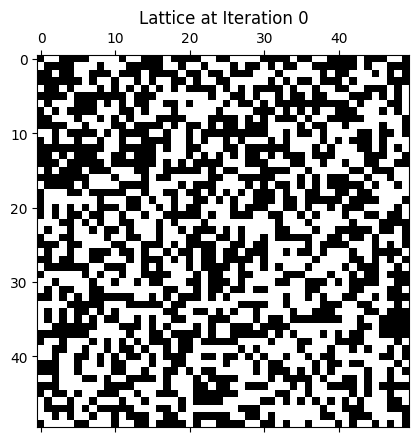

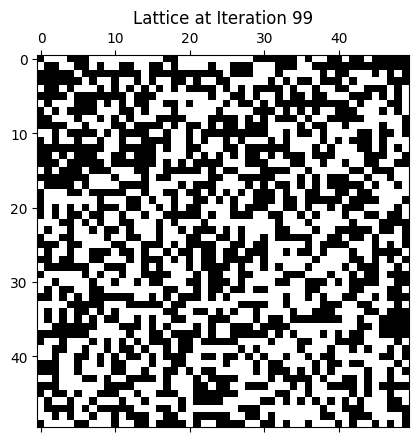

In [139]:
lattice_plots(lattice_history, selected_indices)

### Updating energy
By plotting both the energies of the lattice found by updating the energy in <code> evalutate_particle_move <code> and the energies from evaluating the entire lattice for each iteration with <code> lattice_energy <code>, the updating algoritm is checked. The results agree. 

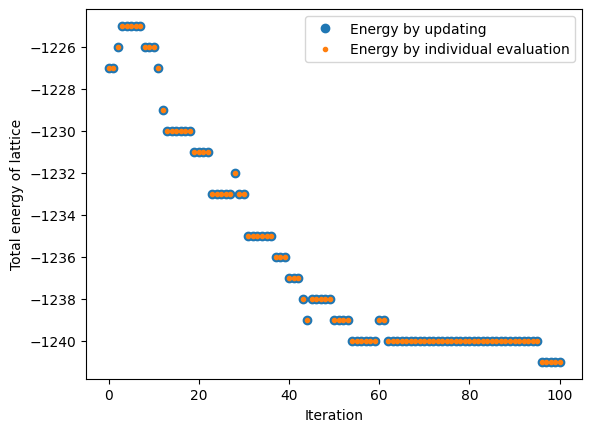

In [140]:
plt.figure()
plt.plot(np.arange(num_runs+1),E_history,'o', label='Energy by updating')
plt.plot(np.arange(num_runs+1),E_lattice2_hist,'.', label = 'Energy by individual evaluation')
plt.ylabel('Total energy of lattice')
plt.xlabel('Iteration')
plt.legend()
plt.show()

## 3.Start moving



In order to study the effect of different densities on the system, the Montecarlo is run for 1_000_000 iterations for every Temperature. Then, this process is repeated for every density on the list keeping the number of particles constant. \
 Even though the first code(the one used to get the data for 1 million runs) is not the most efficient, a new better version with numba is then made.

In [141]:
num_runs = 10_000
T = np.arange(3,0.01,-0.1)
eps = 1        

density_max = 0.9         
size_mini = 50  
number_of_particles = density_max * size_mini**2

density = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
size_list = []
for i, d in enumerate(density):
    size = int(np.sqrt(number_of_particles / d)) ##rho = N/size**2, size = sqrt(N/rho)
    size_list.append(size)

E_history_list=[]
density_list=[]
for i, s in enumerate(size_list):
    E_history, density, run_name = monte_carlo(T, eps, s, number_of_particles, num_runs, num_lattices_to_store=None)
    E_history_list.append(E_history)
    density_list.append(density)

Here a new approach is taken where densities are either increasing or decreasing from the middle point. 

In [142]:
num_runs = 10
T = np.arange(3,0.01,-0.1)
eps = 1        

density_max = 0.9         
size_mini = 50  
number_of_particles = density_max * size_mini**2

densityUp = [0.5, 0.55, 0.6, 0.65, 0.7, 0.8, 0.9]
densityDown = [0.5, 0.45, 0.4, 0.45, 0.3, 0.2, 0.1]
density_approx = densityDown + densityUp        # approximate because densities are found in monte carlo 


executionTimes_numba = []

# with numba 
''' 
@jit
def process_loop(T, eps, density_approx, number_of_particles, num_runs):    

    E_history_tempo_list=[]
    density_tempo_list=[]
    for i, d in enumerate(density_approx):
        size = int(np.sqrt(number_of_particles / d))
        E_history, density, run_name = monte_carlo(T, eps, size, number_of_particles, num_runs, num_lattices_to_store=None)
        E_history_tempo_list.append(E_history)
        density_tempo_list.append(density)
        
    # Sort density_approx and get the indices that would sort it
    sorted_indices = np.argsort(density_approx)

    # Rearrange E_history_list and density_list
    E_history_list = [E_history_tempo_list[i] for i in sorted_indices]
    density_list = [density_tempo_list[i] for i in sorted_indices]
        
    return E_history_tempo_list, density_tempo_list

# Measure execution time
start_time = time.time()

# Process the loop using the optimized function
E_history_list, density_list = process_loop(T, eps, density_approx, number_of_particles, num_runs)

# Calculate execution time
execution_time = time.time() - start_time


exec_string = f'num_runs={num_runs}, time={execution_time}'
executionTimes_numba.append(exec_string)
# Print the execution time
print(f"Execution time WITH NUMBA: {execution_time} seconds")


# Create DataFrames
df_density = pd.DataFrame({'density_list': density_list})
df_E_values = pd.DataFrame({'E_history_list': E_history_list})
'''

' \n@jit\ndef process_loop(T, eps, density_approx, number_of_particles, num_runs):    \n\n    E_history_tempo_list=[]\n    density_tempo_list=[]\n    for i, d in enumerate(density_approx):\n        size = int(np.sqrt(number_of_particles / d))\n        E_history, density, run_name = monte_carlo(T, eps, size, number_of_particles, num_runs, num_lattices_to_store=None)\n        E_history_tempo_list.append(E_history)\n        density_tempo_list.append(density)\n        \n    # Sort density_approx and get the indices that would sort it\n    sorted_indices = np.argsort(density_approx)\n\n    # Rearrange E_history_list and density_list\n    E_history_list = [E_history_tempo_list[i] for i in sorted_indices]\n    density_list = [density_tempo_list[i] for i in sorted_indices]\n        \n    return E_history_tempo_list, density_tempo_list\n\n# Measure execution time\nstart_time = time.time()\n\n# Process the loop using the optimized function\nE_history_list, density_list = process_loop(T, eps, den

In [143]:
def energy_history_plot(T, E_history, size, ratio, num_runs):
    yMin = min(E_history[len(T)-1])-4
    yMax = max(E_history[0])

    # Create subplots
    fig, axes = plt.subplots(len(T), 1, figsize=(8, 2*len(T)))
    fig.suptitle(f'{size} by {size}, density={ratio}')

    for i in range(len(T)):
        ax = axes[i]

        T_formatted = f'{T[i]:.2f}'
        ax.plot(np.arange(0, num_runs), E_history[i], '.', markersize = '1')
        ax.set_yticks(np.arange(yMin, yMax, step = 20))
        ax.set_ylabel(f'Energy (T = {T_formatted})')
        #ax.set_xlabel('Iteration')
        #ax.set_title()

    #plt.tight_layout()
    #plt.savefig('Runs_data/1e6_100x100.svg', format ='svg')
    plt.show()
    
#energy_history_plot(T, E_history, size, ratio, num_runs)

## The Physics

### Pressure relations
$P = -\frac{\partial U}{\partial V} \bigg|_{S,N} $ \, The model is in 2D so the area $A$ constitutes the volume. However, changing the area changes the entropy, so that must be found. 





#### Entropy

The entropy can be found from the heat capacity by thermodynamic integration:

\begin{equation}
 S = S_{ref} + \int_{T_{ref}}^{T} \frac{C_V}{T'} dT'
\end{equation}

By examining the plot of the heat capacity the entropy can be infered at $T \rightarrow \infty$ - or equivalently at the very high $T=3$, where the curve flattens

\begin{equation}
 S_{ref} = \frac{C_V}{T} 
\end{equation}

#### Helmholtz free energy
$U(N,V,T)$, $C_V(N,V,T)$, and $S(N,V,T)$ can be substituted into the definition of the Helmholtz free, $F = U - TS$ and with $P = -\frac{\partial F}{\partial V} \bigg|_{T,N} $ we obtain the expression:

#### Pressure
For the Pressure:
\begin{equation}
   P = \frac{\Delta F}{\Delta V} = \frac{F(V_2) - F(V_1)}{V_2 - V_1}
\end{equation}


In [144]:
def the_physics(T, E_history, ind_equilibrium, density):
    
    mean_energy = []
    Cv_variance = []
    for i in E_history:
        E_mean = np.mean(E_history[i][ind_equilibrium:-1])
        mean_energy.append(E_mean)
        
        E_variance = np.var(E_history[i][ind_equilibrium:-1])
        Cv_var = E_variance/T[i]**2
        Cv_variance.append(Cv_var)
        
    T_MinToMax = T[::-1]
    
    ind_Tmax = np.argmax(max(T))
    S_ref = np.log(density)
    S = S_ref + np.trapz(Cv_variance/T, x=T_MinToMax)

    F = E_mean - T*S

    Cv_gradient = np.gradient(mean_energy,T)

    return mean_energy, Cv_gradient, Cv_variance, S, F



Here is where the iterations that should correspond to the canonical ensemble are selected. This is done because everytime the temperature of the system is changed it takes some interations for it to "adapt". We assume that the last third are in equilibrium since the interations per temperature and considerable.

In [145]:
int(2/3*num_runs) 

6

Here the values for thermodynamic properties are saved and/or calculated. An improvement to the code would start by see the change in run time when lists and replaced by numpy arrays.

In [146]:

ind_equi = int(2/3*num_runs)      # from which iteration equilibrium is assumed 

U_mean_list =[]
Cv_grad_list =[]
Cv_var_list =[]
S_list =[]
F_list =[]

for i in range (len(E_history_list)):
    U_mean, Cv_grad, Cv_var, S, F= the_physics(T, E_history_list[i], ind_equi, density_list[i])
    U_mean_list.append(U_mean)
    Cv_grad_list.append(Cv_grad)
    Cv_var_list.append(Cv_var)
    S_list.append(S)
    F_list.append(F)
#U_mean, Cv_grad, Cv_var, S, F = the_physics(T, E_history, ind_equi)

### Mean Energy

An example of the mean energy behaviour for the lowest density.

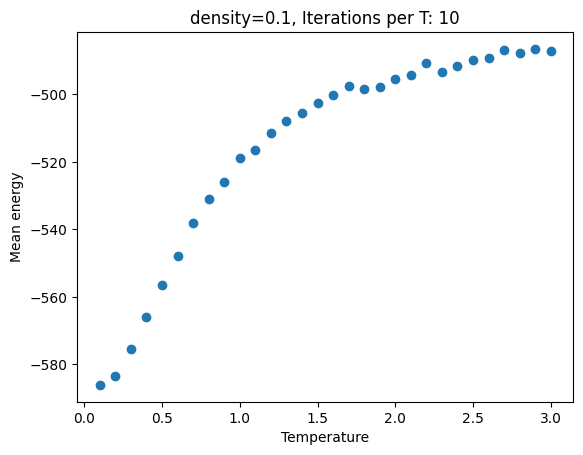

In [147]:

plt.figure()
plt.plot(T,U_mean,'o')
plt.xlabel('Temperature')
plt.ylabel('Mean energy')
plt.title(f'density={density_list[-1]}, Iterations per T: {num_runs}')
#plt.savefig(f'Runs_data/{datetime_str}U_mean.pdf', format = 'pdf')
plt.show()


### Helmholtz Free Energy

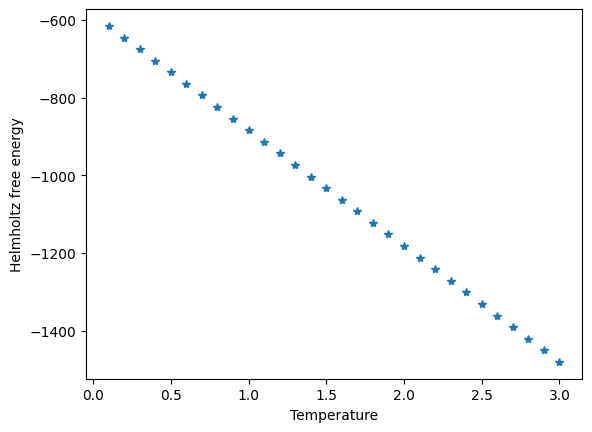

In [148]:
plt.figure()
plt.plot(T,F,'*')
plt.xlabel('Temperature')
plt.ylabel('Helmholtz free energy')
plt.show()

### Heat Capacity

Now we compare the heat capacities found from the gradient and the variance, respectively. Since they agree we presume equilibrium is indeed the case. 

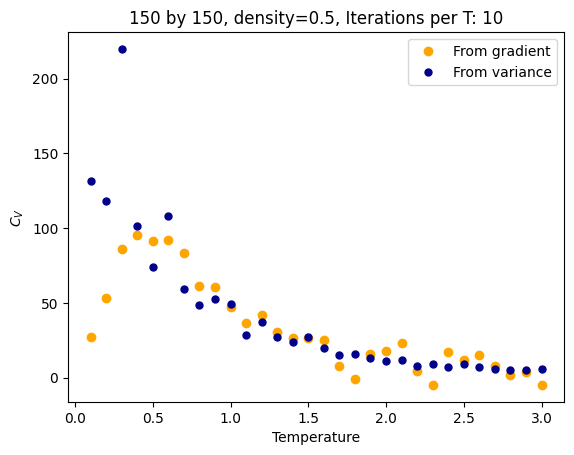

In [149]:

   
plt.figure()
plt.plot(T,Cv_grad,'o', color = 'orange', label = 'From gradient')
plt.plot(T,Cv_var, '.', markersize = '10', color = 'darkblue', label = 'From variance')
plt.xlabel('Temperature')
plt.ylabel('$C_{V}$')
plt.title(f'{size} by {size}, density={ratio}, Iterations per T: {num_runs}')
plt.legend()
#plt.savefig(f'Runs_data/{datetime_str}Cv.png')
plt.show()


Now get the Pressure and evaluate the critical temperature for each density. 

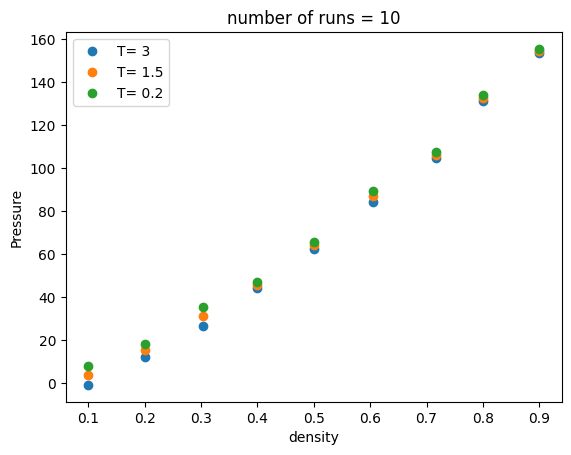

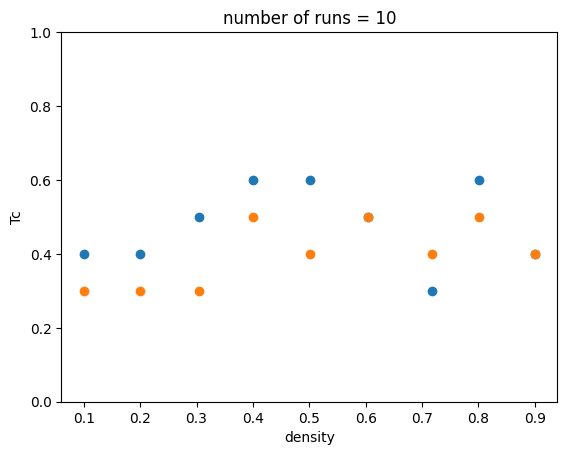

In [150]:
def Extract(lst, index):
    return [item[index] for item in lst]
  
def Max_index_extract(lst): ###get the index of max value of a list of lists
    index_list =[]
    for list in lst:
        max_list = np.argmax(list)
        index_list.append( max_list )
    return index_list

P= - np.gradient(Extract(F_list,0),size_list)
P2= - np.gradient(Extract(F_list,15),size_list)
P3= - np.gradient(Extract(F_list,28),size_list)

Tc_list =[]
for Tc_index in Max_index_extract(Cv_grad_list) :
    Tc_list.append(T[Tc_index])
Tc_list2=[]
for Tc_index in Max_index_extract(Cv_var_list) :
    Tc_list2.append(T[Tc_index])
    
plt.figure()
plt.plot(density_list,-P,'o')
plt.plot(density_list,-P2,'o')
plt.plot(density_list,-P3,'o')
plt.xlabel('density')
plt.ylabel('Pressure')
plt.legend(['T= 3','T= 1.5','T= 0.2'])
plt.title(f'number of runs = {num_runs}')

plt.show()

index_Temp =[]

plt.figure()
plt.plot( density_list,Tc_list,'o')
plt.plot( density_list,Tc_list2,'o')
plt.xlabel('density')
plt.ylabel('Tc')
plt.title(f'number of runs = {num_runs}')
plt.ylim(0,1)

plt.show()


By the graphs it becomes visible that the pressure is more intense for higher densities, as expected. 

### Heat Capacity Polynomial Fitting

        9         8        7        6        5        4        3
-12.36 x + 180.1 x - 1104 x + 3686 x - 7238 x + 8358 x - 5259 x
         2
 + 1376 x + 38.33 x - 12.84


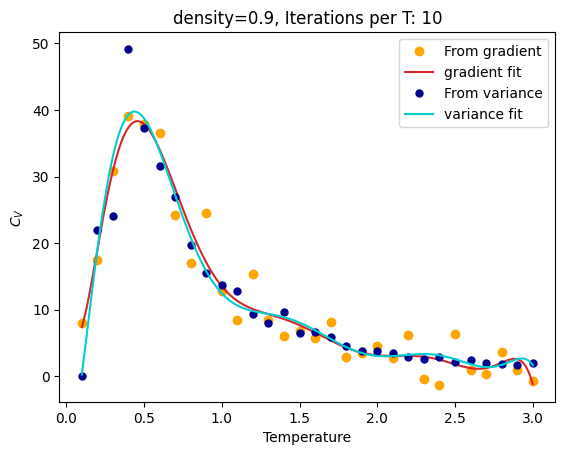

        9         8        7        6             5             4
-22.02 x + 327.2 x - 2062 x + 7165 x - 1.494e+04 x + 1.898e+04 x
              3        2
 - 1.418e+04 x + 5562 x - 861.8 x + 42.94


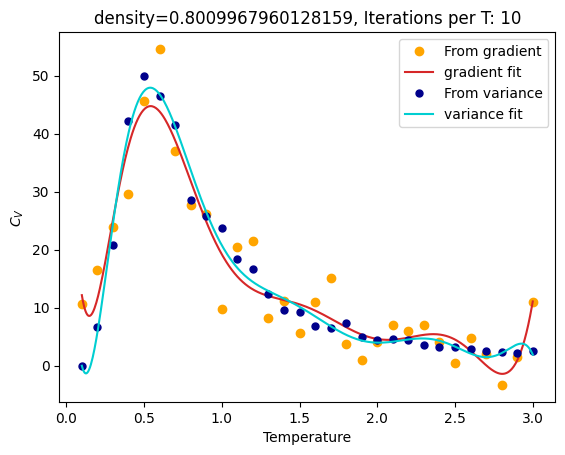

        9         8        7        6        5        4        3
-14.51 x + 208.4 x - 1258 x + 4123 x - 7918 x + 8868 x - 5292 x
         2
 + 1176 x + 142 x - 22.66


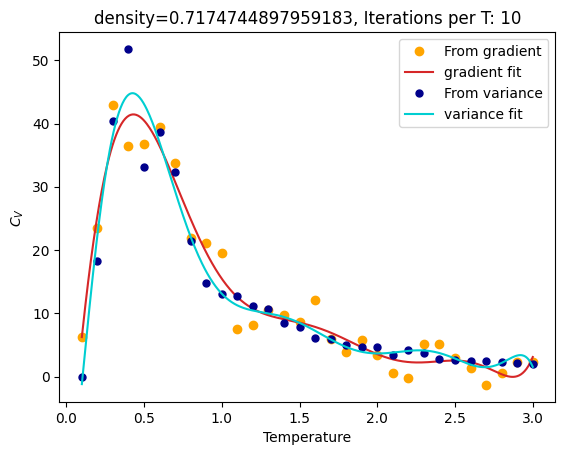

        9         8        7             6             5             4
-55.17 x + 821.8 x - 5191 x + 1.807e+04 x - 3.773e+04 x + 4.802e+04 x
              3             2
 - 3.608e+04 x + 1.455e+04 x - 2535 x + 141.7


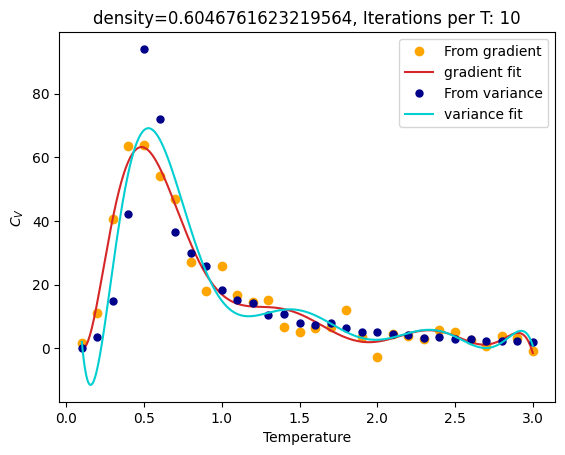

        9         8        7        6             5            4
-27.08 x + 386.1 x - 2313 x + 7546 x - 1.448e+04 x + 1.64e+04 x
              3        2
 - 1.023e+04 x + 2784 x - 27.27 x - 17.81


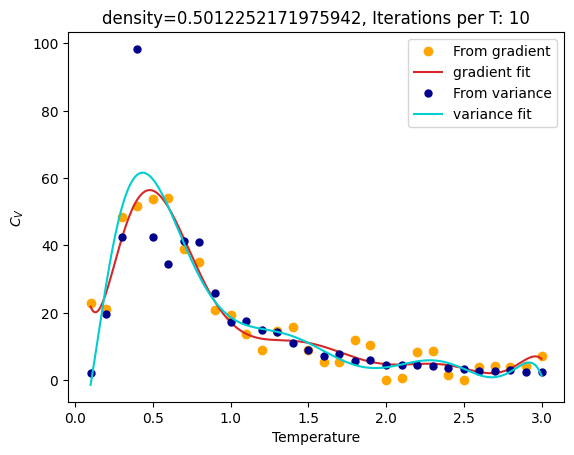

        9         8        7        6             5             4
-29.01 x + 433.4 x - 2749 x + 9624 x - 2.023e+04 x + 2.595e+04 x
              3        2
 - 1.961e+04 x + 7831 x - 1266 x + 66.67


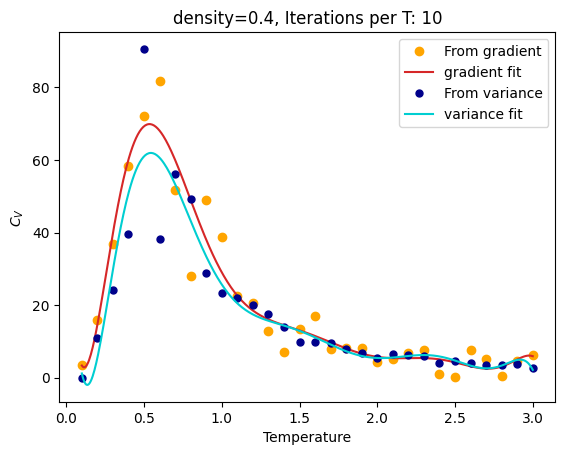

        9         8        7        6        5        4        3
-12.43 x + 177.6 x - 1060 x + 3401 x - 6237 x + 6253 x - 2547 x
          2
 - 663.3 x + 787.2 x - 71.89


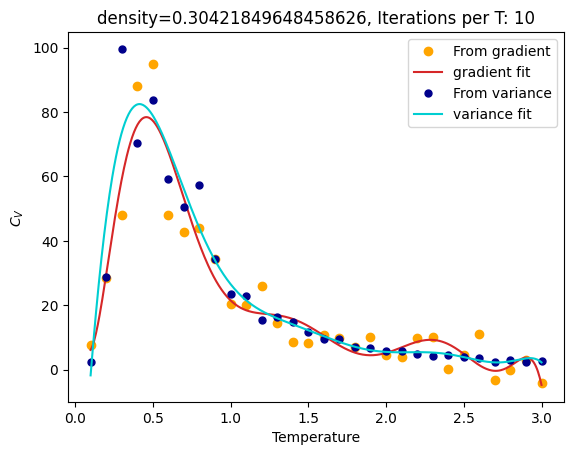

       9         8        7        6             5             4
28.21 x - 407.5 x + 2482 x - 8274 x + 1.641e+04 x - 1.968e+04 x
              3        2
 + 1.391e+04 x - 5395 x + 960.9 x + 10.53


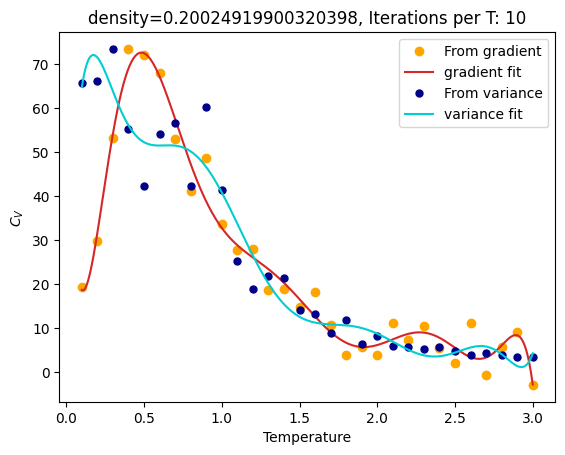

       9         8         7        6        5            4
7.556 x - 130.2 x + 960.6 x - 3954 x + 9913 x - 1.55e+04 x
              3        2
 + 1.481e+04 x - 7995 x + 1938 x - 4.407


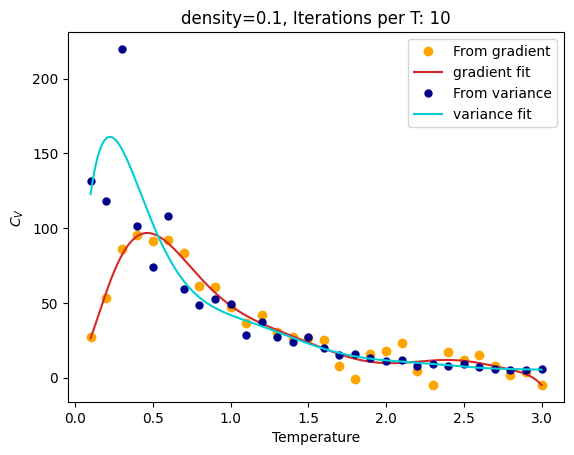

In [151]:
p_grad_list = []
p_var_list = []
xp = np.linspace(min(T), max(T), 500)
for run_idx in range(len(Cv_grad_list)):
    
    p_grad = np.poly1d(np.polyfit(T, Cv_grad_list[run_idx],  9))
    p_grad_list.append(p_grad)
    p_var = np.poly1d(np.polyfit(T, Cv_var_list[run_idx],  9))
    p_var_list.append(p_var)
    
    print(p_var)
    
    plt.figure()
    plt.plot(T, Cv_grad_list[run_idx], 'o', color = 'orange', label = 'From gradient')
    plt.plot(xp, p_grad(xp), color='C3', label = 'gradient fit')
    plt.plot(T, Cv_var_list[run_idx], '.', markersize=10, color = 'darkblue', label = 'From variance')
    plt.plot(xp, p_var(xp), color = 'darkturquoise', label = 'variance fit')
    plt.xlabel('Temperature')
    plt.ylabel('$C_{V}$')
    plt.title(f'density={density_list[run_idx]}, Iterations per T: {num_runs}')
    plt.legend()
    plt.show()

In [152]:
Tc_gradSketchy_list = []
Tc_varSketchy_list = []
for run_idx in range(len(Cv_grad_list)):
    
    # Sketchy
    Tc_gradSketchy, Tc_gradSketchy_index = critical_temperature(p_grad_list[run_idx](xp), xp)
    Tc_gradSketchy_list.append(Tc_gradSketchy)
    
    Tc_varSketchy, Tc_varSketchy_index = critical_temperature(p_var_list[run_idx](xp), xp)
    Tc_varSketchy_list.append(Tc_varSketchy)
    
plt.figure()
plt.plot(density_list, Tc_gradSketchy_list, 'o', color = 'C3', label = 'From gradient')
plt.plot(density_list, Tc_varSketchy_list, '.', markersize = '10', color = 'darkturquoise', label = 'From variance')
plt.ylim(0, 1.5)
plt.xlabel('Density')
plt.ylabel('Temperature')
plt.legend()
plt.title(f'Sketchy Critical temperature, Iterations:{num_runs}')
plt.show()

NameError: name 'critical_temperature' is not defined